In [1]:
# ================================
# 1. IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
import json
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, GlobalMaxPooling1D,
                                     BatchNormalization, LayerNormalization, Add,
                                     Bidirectional, MultiHeadAttention)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras import regularizers
from tensorflow.keras import layers, models, callbacks, utils
from scikeras.wrappers import KerasClassifier
from sklearn.manifold import TSNE
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = "artifacts"
visualization_dir = "visualization"
checkpoint_dir = 'checkpoints'

os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {visualization_dir}")
print(f"Checkpoints will be saved in: {checkpoint_dir}")

All libraries imported successfully!
TensorFlow version: 2.18.0
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization
Checkpoints will be saved in: checkpoints


In [2]:
with open(os.path.join(artifacts_dir, 'data_preprocessing.pkl'), 'rb') as f:
    X_filtered, y_encoded = pickle.load(f)

In [2]:
df = pd.read_csv(r'D:\Skripsi\Model\Model Garage Door\Data Preprocessing\artifacts\data_preprocessing.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully!
Dataset shape: (39587, 10)


In [3]:
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())


DATASET OVERVIEW
   is_weekend  hour_sin  hour_cos   min_sin   min_cos  time_diff  \
0         1.0  0.508666       0.0  0.043227  0.296632        0.0   
1         1.0  0.508666       0.0  0.043227  0.296632        0.0   
2         1.0  0.508666       0.0  0.043227  0.296632        0.0   
3         1.0  0.508666       0.0  0.043227  0.296632        0.0   
4         1.0  0.508666       0.0  0.043227  0.296632        0.0   
5         1.0  0.508666       0.0  0.043227  0.296632        0.0   
6         1.0  0.508666       0.0  0.043227  0.296632        0.0   
7         1.0  0.508666       0.0  0.043227  0.296632        0.0   
8         1.0  0.508666       0.0  0.043227  0.296632        0.0   
9         1.0  0.508666       0.0  0.043227  0.296632        0.0   

   door_state_encoded  phone_dom_freq  phone_entropy  label  
0                 0.0             0.0            0.0      3  
1                 0.0             0.0            0.0      3  
2                 0.0             0.0          

In [4]:
X = df.copy()
y = df['label'].copy()
X.drop('label', axis=1, inplace=True)

In [10]:
print(X.info())
print('\n',X.shape)
print('\n',y.shape)
print('\n',y.value_counts())
print('\n',X.head(5))
print('\n',y[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_weekend          39587 non-null  float64
 1   hour_sin            39587 non-null  float64
 2   hour_cos            39587 non-null  float64
 3   min_sin             39587 non-null  float64
 4   min_cos             39587 non-null  float64
 5   time_diff           39587 non-null  float64
 6   door_state_encoded  39587 non-null  float64
 7   phone_dom_freq      39587 non-null  float64
 8   phone_entropy       39587 non-null  float64
dtypes: float64(9)
memory usage: 2.7 MB
None

 (39587, 9)

 (39587,)

 label
3    15000
2     5000
1     5000
4     5000
0     5000
5     2902
7     1156
6      529
Name: count, dtype: int64

    is_weekend  hour_sin  hour_cos   min_sin   min_cos  time_diff  \
0         1.0  0.508666       0.0  0.043227  0.296632        0.0   
1         1.0  0.508666 

In [ ]:
# Split data
# === 1. Split data menjadi train, val, test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_temp, y_val, y_temp = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

X_train_ae = X_train.copy()
y_train_ae = y_train.copy()

# === 4. Print distribusi label ===
def print_label_dis(y, label_name):
    print(f"\nClass distribution in {label_name}:")
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} ({100*count/total:.2f}%)")

# === 5. Print statistik dataset ===
print(f"\nDataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")
print(f"X_train_ae: {X_train_ae.shape}, y_train_ae: {y_train_ae.shape}")

print_label_dis(y_train, "Training Set")
print_label_dis(y_val, "Validation Set")
print_label_dis(y_test, "Test Set")


Dataset shapes:
X_train: (31669, 9), y_train: (31669,)
X_val:   (28502, 9), y_val:   (28502,)
X_test:  (7918, 9), y_test:  (7918,)
X_train_ae: (31669, 9), y_train_ae: (31669,)

Class distribution in Training Set:
Class 0: 4000 (12.63%)
Class 1: 4000 (12.63%)
Class 2: 4000 (12.63%)
Class 3: 12000 (37.89%)
Class 4: 4000 (12.63%)
Class 5: 2321 (7.33%)
Class 6: 423 (1.34%)
Class 7: 925 (2.92%)

Class distribution in Validation Set:
Class 0: 3600 (12.63%)
Class 1: 3600 (12.63%)
Class 2: 3600 (12.63%)
Class 3: 10800 (37.89%)
Class 4: 3600 (12.63%)
Class 5: 2089 (7.33%)
Class 6: 381 (1.34%)
Class 7: 832 (2.92%)

Class distribution in Test Set:
Class 0: 1000 (12.63%)
Class 1: 1000 (12.63%)
Class 2: 1000 (12.63%)
Class 3: 3000 (37.89%)
Class 4: 1000 (12.63%)
Class 5: 581 (7.34%)
Class 6: 106 (1.34%)
Class 7: 231 (2.92%)


In [5]:
print(X_train.info())
print("\ndata train lstm: ", X_train.shape)
print("\ndata train ae: ", X_train_ae.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 31669 entries, 30534 to 38533
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_weekend          31669 non-null  float64
 1   hour_sin            31669 non-null  float64
 2   hour_cos            31669 non-null  float64
 3   min_sin             31669 non-null  float64
 4   min_cos             31669 non-null  float64
 5   time_diff           31669 non-null  float64
 6   door_state_encoded  31669 non-null  float64
 7   phone_dom_freq      31669 non-null  float64
 8   phone_entropy       31669 non-null  float64
dtypes: float64(9)
memory usage: 2.4 MB
None

data train lstm:  (31669, 9)

data train ae:  (31669, 9)


In [8]:
def oversample_normal_undersample_attack(X, y, normal_label, target_size):
    normal_ratio = 0.9
    target_normal_size = int(target_size * normal_ratio)
    target_attack_total = target_size - target_normal_size

    # Split normal and attack
    X_normal = X[y == normal_label]
    y_normal = y[y == normal_label]

    X_attack = X[y != normal_label]
    y_attack = y[y != normal_label]

    # Oversample normal class manually
    X_normal_os, y_normal_os = resample(
        X_normal, y_normal,
        replace=True,
        n_samples=target_normal_size,
        random_state=42
    )

    # Undersample attack classes equally
    unique_attacks = np.unique(y_attack)
    samples_per_class = target_attack_total // len(unique_attacks)

    X_attack_us, y_attack_us = [], []
    total_attack_sampled = 0

    for cls in unique_attacks:
        X_cls = X[y == cls]
        y_cls = y[y == cls]

        n_samples_cls = min(samples_per_class, len(X_cls))
        total_attack_sampled += n_samples_cls

        X_cls_sampled, y_cls_sampled = resample(
            X_cls, y_cls,
            replace=False,
            n_samples=n_samples_cls,
            random_state=42
        )
        X_attack_us.append(X_cls_sampled)
        y_attack_us.append(y_cls_sampled)

    # Jika undersampling attack total kurang dari target_attack_total, tambahkan sisa sampel secara acak dari seluruh attack data
    deficit = target_attack_total - total_attack_sampled
    if deficit > 0:
        X_attack_pool = np.vstack(X_attack_us) if len(X_attack_us) > 0 else np.empty((0, X.shape[1]))
        y_attack_pool = np.hstack(y_attack_us) if len(y_attack_us) > 0 else np.empty((0, ))

        # Cari data attack yang belum terambil
        mask_selected = np.zeros(len(X_attack), dtype=bool)
        for x_sample in X_attack_pool:
            idx = np.where((X_attack == x_sample).all(axis=1))[0]
            mask_selected[idx] = True
        X_attack_remaining = X_attack[~mask_selected]
        y_attack_remaining = y_attack[~mask_selected]

        if len(X_attack_remaining) >= deficit:
            X_extra, y_extra = resample(
                X_attack_remaining, y_attack_remaining,
                replace=False,
                n_samples=deficit,
                random_state=42
            )
        else:
            # Jika tidak cukup data tersisa, ambil semua dan oversample sisanya
            X_extra, y_extra = resample(
                X_attack_remaining, y_attack_remaining,
                replace=True,
                n_samples=deficit,
                random_state=42
            )

        X_attack_us.append(X_extra)
        y_attack_us.append(y_extra)

    # Combine all
    X_final = np.vstack([X_normal_os] + X_attack_us)
    y_final = np.hstack([y_normal_os] + y_attack_us)

    # Jika masih belum sesuai karena pembulatan, lakukan trimming atau penambahan duplicate
    if len(X_final) > target_size:
        X_final = X_final[:target_size]
        y_final = y_final[:target_size]
    elif len(X_final) < target_size:
        needed = target_size - len(X_final)
        X_extra, y_extra = resample(
            X_final, y_final,
            replace=True,
            n_samples=needed,
            random_state=42
        )
        X_final = np.vstack([X_final, X_extra])
        y_final = np.hstack([y_final, y_extra])

    return X_final, y_final

In [9]:
X_ae_sm, y_ae_sm = oversample_normal_undersample_attack(
    X_train_ae, y_train_ae,
    normal_label=3,
    target_size=X_train.shape[0]
)

In [10]:
print(X_ae_sm.shape)
print(X_train.shape)

(31669, 9)
(31669, 9)


In [13]:
# ================================
# 9. PREPARE DATA FOR LSTM
# ================================

print("\n" + "="*50)
print("PREPARING DATA FOR LSTM")
print("="*50)

def create_sequences(X, y, sequence_length=10):
    """Create sequences for LSTM input"""
    X_seq, y_seq = [], []
    
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

# Set sequence length
SEQUENCE_LENGTH = 15

# Create sequences
X_train_lstm_seq, y_train_lstm_seq = create_sequences(X_train.values, y_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val.values, y_val, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test, SEQUENCE_LENGTH)

X_train_ae_seq, y_train_ae_seq = create_sequences(X_ae_sm, y_ae_sm, SEQUENCE_LENGTH)

print(f"Training sequences shape: {X_train_lstm_seq.shape}")
print(f"Training label sequences shape: {y_train_lstm_seq.shape}")
print(f"\nValidation sequences shape: {X_val_seq.shape}")
print(f"Validation label sequences shape: {y_val_seq.shape}")
print(f"\nTest sequences shape: {X_test_seq.shape}")
print(f"Test label sequences shape: {y_test_seq.shape}")

print(f"\nTraining AE sequences shape: {X_train_ae_seq.shape}")
print(f"Training AE label sequences shape: {y_train_ae_seq.shape}")


PREPARING DATA FOR LSTM
Training sequences shape: (31654, 15, 9)
Training label sequences shape: (31654,)

Validation sequences shape: (28487, 15, 9)
Validation label sequences shape: (28487,)

Test sequences shape: (7903, 15, 9)
Test label sequences shape: (7903,)

Training AE sequences shape: (31654, 15, 9)
Training AE label sequences shape: (31654,)


In [14]:
# Convert to categorical for multi-class classification
num_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train_lstm_seq, num_classes)
y_val_cat = to_categorical(y_val_seq, num_classes)
y_test_cat = to_categorical(y_test_seq, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Categorical target train shape: {y_train_cat.shape}")
print(f"Categorical target val shape: {y_val_cat.shape}")
print(f"Categorical target test shape: {y_test_cat.shape}")

Number of classes: 8
Categorical target train shape: (31654, 8)
Categorical target val shape: (28487, 8)
Categorical target test shape: (7903, 8)


In [34]:
def compute_alpha_from_labels(y_labels):
    """
    y_labels: array of integer labels, e.g. y_train_seq (not one-hot)
    returns: normalized alpha array for focal loss
    """
    label_counter = Counter(y_labels)
    total = sum(label_counter.values())

    # Urutkan berdasarkan index label (0..N)
    num_classes = max(label_counter.keys()) + 1
    counts = np.array([label_counter.get(i, 0) for i in range(num_classes)], dtype=np.float32)

    # Hitung alpha sebagai kebalikan proporsi, lalu normalisasi
    alpha_raw = 1.0 / (counts / total)
    alpha_normalized = alpha_raw / np.sum(alpha_raw)

    return alpha_normalized.astype(np.float32)

In [35]:
def focal_loss_with_alpha(gamma=2.0, alpha=None):
    def loss(y_true, y_pred):
        # Konversi y_true ke one-hot
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Hindari log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Alpha weighting
        if alpha is not None:
            alpha_tensor = tf.convert_to_tensor(alpha, dtype=tf.float32)
            alpha_factor = tf.reduce_sum(alpha_tensor * y_true, axis=-1)
        else:
            alpha_factor = 1.0

        # Focal weighting
        focal_weight = tf.reduce_sum(tf.pow(1.0 - y_pred, gamma) * y_true, axis=-1)

        loss_val = alpha_factor * focal_weight * tf.reduce_sum(cross_entropy, axis=-1)
        return tf.reduce_mean(loss_val)
    return loss

In [38]:
alpha = compute_alpha_from_labels(y_train_lstm_seq)
print("Alpha untuk masing-masing kelas:", alpha)

Alpha untuk masing-masing kelas: [0.05041842 0.05041842 0.05040581 0.01680754 0.05041842 0.0868474
 0.47653154 0.21815242]


In [39]:
loss_fn = focal_loss_with_alpha(gamma=2.0, alpha=alpha)

In [17]:
print(X_train_lstm_seq.shape[2])
print(X_train_lstm_seq.shape[1])
print(X_train_lstm_seq.shape[0])

9
15
31654


In [56]:
sequence_length = X_train_lstm_seq.shape[1]
n_features = X_train_lstm_seq.shape[2]
n_classes = num_classes

inputs = Input(shape=(sequence_length, n_features))

x = Bidirectional(LSTM(64, return_sequences=False))(inputs)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(n_classes, activation='softmax')(x)

# Model instantiation
classifier = Model(inputs=inputs, outputs=output, name='Classifier')
classifier.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=1e-3),
    metrics=['accuracy']
)
classifier.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 15, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,664 (182.28 KB)

 Trainable params: 46,664 (182.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Parameter (ganti dengan nilai sesuai kebutuhanmu)
sequence_length = X_train_lstm_seq.shape[1]
n_features = X_train_lstm_seq.shape[2]
n_classes = num_classes
lstm_units = 128
attention_units = 64

# Input layer
inputs = Input(shape=(sequence_length, n_features))

# Bidirectional LSTM stack
lstm_out = Bidirectional(
    LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
)(inputs)

lstm_out = Bidirectional(
    LSTM(lstm_units // 2, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
)(lstm_out)

# Self-attention mechanism (Multi-head)
attention = MultiHeadAttention(
    num_heads=8,
    key_dim=attention_units,
    dropout=0.1
)(lstm_out, lstm_out)

# Add & Normalize (residual connection)
attention = Add()([lstm_out, attention])
attention = LayerNormalization()(attention)

# Pooling untuk mengubah 3D ke 2D
pooled = GlobalMaxPooling1D()(attention)

# Fully Connected Layers
dense = Dense(128, activation='relu')(pooled)
dense = BatchNormalization()(dense)
dense = Dropout(0.3)(dense)

dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.2)(dense)

# Output layer
outputs = Dense(n_classes, activation='softmax')(dense)

# Model instantiation
classifier = Model(inputs=inputs, outputs=outputs, name='Classifier')
classifier.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
classifier.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 15, 256)   │    141,312 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 15, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │    263,808 │ bidirectional_1[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 128)   │          0 │ bidirectional_1[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 15, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        520 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 595,528 (2.27 MB)

 Trainable params: 595,272 (2.27 MB)

 Non-trainable params: 256 (1.00 KB)

In [57]:
# Callback
early_stop = EarlyStopping(
    monitor='val_loss',        # berhenti jika val_loss tidak membaik
    patience=10,               # toleransi 10 epoch
    restore_best_weights=True # ambil bobot terbaik
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]

# class_weight
# Calculate class weights for imbalanced data
raw_weights = compute_class_weight('balanced', classes=np.unique(y_train_lstm_seq), y=y_train_lstm_seq)
# Gunakan log transform agar tidak ekstrem
scaled_weights = np.log1p(raw_weights)
# Normalisasi supaya rata-rata = 1
normalized_weights = scaled_weights / np.mean(scaled_weights)
# Konversi ke dict
class_weight_dict = dict(enumerate(normalized_weights))
print("Final class weights:", class_weight_dict)
cls_sample_weights = np.array([class_weight_dict[label] for label in y_train_lstm_seq])
print("Sample weights shape:", cls_sample_weights.shape)

Final class weights: {0: 0.6850953739033226, 1: 0.6850953739033226, 2: 0.6849715039250392, 3: 0.2839265954887917, 4: 0.6850953739033226, 5: 0.9908487275693599, 6: 2.327591305718722, 7: 1.6573757455881182}
Sample weights shape: (31654,)


In [58]:
history = classifier.fit(
    X_train_lstm_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    # class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/30
494/495 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3652 - loss: 1.8150
Epoch 1: val_loss improved from inf to 1.76816, saving model to checkpoints\best_model.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3653 - loss: 1.8149 - val_accuracy: 0.3789 - val_loss: 1.7682 - learning_rate: 0.0010
Epoch 2/30
491/495 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3750 - loss: 1.7829
Epoch 2: val_loss improved from 1.76816 to 1.76716, saving model to checkpoints\best_model.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3750 - loss: 1.7828 - val_accuracy: 0.3789 - val_loss: 1.7672 - learning_rate: 0.0010
Epoch 3/30
488/495 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3749 - loss: 1.7773
Epoch 3: val_loss improved from 1.76716 to 1.76678, saving model to checkpoints\best_model.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3750 - loss: 1.7772 - val_accuracy: 0.3789 - val_loss: 1.7668 - learning_rate: 0.0010
Epoch 4/30
493/495 ━━━━━━━━━━━━━

In [45]:
print('y train:')
print(y_train_cat.shape)
print(y_train_cat[:5])

print('\ny val:')
print(y_val_cat.shape)
print(y_val_cat[:5])

y train:
(31654, 8)
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]

y val:
(28487, 8)
[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [27]:
print(np.unique(y_encoded, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 5000,  5000,  5000, 15000,  5000,  2902,   529,  1156],
      dtype=int64))


In [32]:
print('Hasil prediksi model:')
classifier.predict(X_train_lstm_seq[:10])

Hasil prediksi model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[0.15949412, 0.11571546, 0.14915389, 0.224301  , 0.13751116,
        0.13154677, 0.02233692, 0.05994076],
       [0.1591552 , 0.11631775, 0.14858672, 0.22458471, 0.13849154,
        0.13062593, 0.02234523, 0.05989292],
       [0.16055559, 0.11780465, 0.1474144 , 0.22134021, 0.13820468,
        0.13293482, 0.0218084 , 0.05993725],
       [0.16014442, 0.11704721, 0.1480187 , 0.2223922 , 0.13864738,
        0.13273682, 0.02187281, 0.05914047],
       [0.15939598, 0.11567051, 0.14805615, 0.22505951, 0.13788432,
        0.13211128, 0.02216054, 0.05966171],
       [0.157556  , 0.1147057 , 0.14852342, 0.22796592, 0.13678314,
        0.1307942 , 0.02297952, 0.060692  ],
       [0.15621747, 0.11347461, 0.14968233, 0.22880475, 0.13526691,
        0.13056296, 0.02394201, 0.06204904],
       [0.15214261, 0.11518343, 0.15072729, 0.2323031 , 0.13511182,
        0.12599999, 0.02654511, 0.06198659],
       [0.15631089, 0.11393839, 0.149306  , 0.22847158, 0.13602616,
        0.1301596 , 0.024039

In [33]:
y_pred = classifier.predict(X_val_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val_cat, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

891/891 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3596
           1       0.00      0.00      0.00      3599
           2       0.00      0.00      0.00      3599
           3       0.38      1.00      0.55     10794
           4       0.00      0.00      0.00      3598
           5       0.00      0.00      0.00      2088
           6       0.00      0.00      0.00       381
           7       0.00      0.00      0.00       832

    accuracy                           0.38     28487
   macro avg       0.05      0.12      0.07     28487
weighted avg       0.14      0.38      0.21     28487



In [ ]:
# --- Autoencoder (Anomaly Detection) ---
ae_input = Input(shape=(timesteps, n_features_ae))
enc_1 = layers.LSTM(32, return_sequences=True)(ae_input)
enc_2 = layers.LSTM(16, return_sequences=False)(enc_1)
latent = layers.Dense(8, activation='relu', name='latent_space')(enc_2)

dec_rep = layers.RepeatVector(timesteps)(latent)
dec_1 = layers.LSTM(16, return_sequences=True)(dec_rep)
dec_2 = layers.LSTM(32, return_sequences=True)(dec_1)
ae_out = layers.TimeDistributed(layers.Dense(n_features_ae), name='ae_out')(dec_2)

Anomaly_Detection = models.Model(ae_input, ae_out, name='Anomaly_Detection')

# --- Hybrid Model ---
combined_input_cls = Input(shape=(timesteps, n_features_lstm), name='hyb_cls_in')
combined_input_ae = Input(shape=(timesteps, n_features_ae), name='hyb_ae_in')
cls_pred = Classifier(combined_input_cls)
ad_pred = Anomaly_Detection(combined_input_ae)
Hybrid_Model = models.Model(
    inputs=[combined_input_cls, combined_input_ae],
    outputs={'cls_out': cls_pred, 'ae_out': ad_pred},
    name='Hybrid_Model'
)

Anomaly_Detection.compile(loss='mse', optimizer=Adam(), metrics=['mse'])
Hybrid_Model.compile(optimizer='adam',
                     loss={'cls_out': 'categorical_crossentropy', 'ae_out': 'mse'},
                     loss_weights={'cls_out': 0.7, 'ae_out': 0.3},
                     metrics={'Classifier': 'accuracy', 'Anomaly_Detection': 'mse'})

Anomaly_Detection.summary()
Hybrid_Model.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 10, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 10, 128)   │     39,936 │ input_layer_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 10, 64)    │     41,216 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 10, 64)    │          0 │ bidirectional_7[… │
│ (Attention)         │                   │            │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pool      │ (None, 64)        │          0 │ attention_layer[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ attention_pool[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_out (Dense)     │ (None, 8)         │        264 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,496 (326.16 KB)

 Trainable params: 83,496 (326.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Anomaly_Detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 10, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 10, 32)         │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 10, 16)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 10, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_out (TimeDistributed)        │ (None, 10, 13)         │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,461 (68.21 KB)

 Trainable params: 17,461 (68.21 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ hyb_ae_in           │ (None, 10, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hyb_cls_in          │ (None, 10, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Anomaly_Detection   │ (None, 10, 13)    │     17,461 │ hyb_ae_in[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Classifier          │ (None, 8)         │     83,496 │ hyb_cls_in[0][0]  │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,957 (394.36 KB)

 Trainable params: 100,957 (394.36 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# Calculate class weights for imbalanced data
raw_weights = compute_class_weight('balanced', classes=np.unique(y_train_lstm_seq), y=y_train_lstm_seq)
# Gunakan log transform agar tidak ekstrem
scaled_weights = np.log1p(raw_weights)
# Normalisasi supaya rata-rata = 1
normalized_weights = scaled_weights / np.mean(scaled_weights)
# Konversi ke dict
class_weight_dict = dict(enumerate(normalized_weights))
print("Final class weights:", class_weight_dict)
cls_sample_weights = np.array([class_weight_dict[label] for label in y_train_lstm_seq])
print("Sample weights shape:", cls_sample_weights.shape)

Final class weights: {0: 0.684908379212814, 1: 0.6850322093185396, 2: 0.6850322093185396, 3: 0.28393775408480415, 4: 0.6850322093185396, 5: 0.9909225173580166, 6: 2.3276738615824724, 7: 1.657460859806274}
Sample weights shape: (31659,)


In [17]:
print("X_train shape:", X_train_lstm_seq.shape)
print("y_train_cat shape:", y_train_cat.shape)

print("X_val shape:", X_val_seq.shape)
print("y_val_cat shape:", y_val_cat.shape)

X_train shape: (31659, 10, 13)
y_train_cat shape: (31659, 8)
X_val shape: (28492, 10, 13)
y_val_cat shape: (28492, 8)


In [29]:
history_cls = Classifier.fit(
    X_train_lstm_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=50, batch_size=32,
    callbacks = callbacks,
    class_weight = class_weight_dict,
    verbose=1
)

Epoch 1/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.3322 - loss: 1.2297 - val_accuracy: 0.3789 - val_loss: 1.9286 - learning_rate: 0.0010
Epoch 2/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3752 - loss: 1.2258 - val_accuracy: 0.3789 - val_loss: 1.9267 - learning_rate: 0.0010
Epoch 3/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3757 - loss: 1.2254 - val_accuracy: 0.3789 - val_loss: 1.9284 - learning_rate: 0.0010
Epoch 4/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3758 - loss: 1.2254 - val_accuracy: 0.3789 - val_loss: 1.9285 - learning_rate: 0.0010
Epoch 5/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.3758 - loss: 1.2253 - val_accuracy: 0.3789 - val_loss: 1.9252 - learning_rate: 0.0010
Epoch 6/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.3758 - loss: 1.2251 - val_accuracy: 0.3789 - val_loss: 1.9289 - learning_rate: 0.0010
Epoch 7/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3758 - l

In [ ]:
# -------------------------
# 2. TRAINING
# -------------------------
y_train_zero = np.zeros((X_train_ae_seq.shape[0], timesteps, n_features_ae))
Hybrid_Model.fit(
    x=[X_train_lstm_seq, X_train_ae_seq],
    y={ 'cls_out' : y_train_cat, 'ae_out' : X_train_ae_seq},
    validation_data=([X_val_seq, X_val_seq], {'cls_out' : y_val_cat, 'ae_out' : X_val_seq}),
    # sample_weight={
    #     'cls_out' : cls_sample_weights,
    #     'ae_out': np.ones(X_train_ae_seq.shape[0])
    # },
    callbacks = callbacks,
    epochs=20,
    batch_size=32,
    verbose=1
)


In [ ]:
print('X_train_lstm_seq shape:', X_train_lstm_seq.shape)  # e.g. (N, 10, 13)
print('X_train_ae_seq shape:', X_train_ae_seq.shape)      # harus (N, 10, 13)
print('y_train_cat shape:', y_train_cat.shape)            # harus (N, n_classes)



MODEL EVALUATION


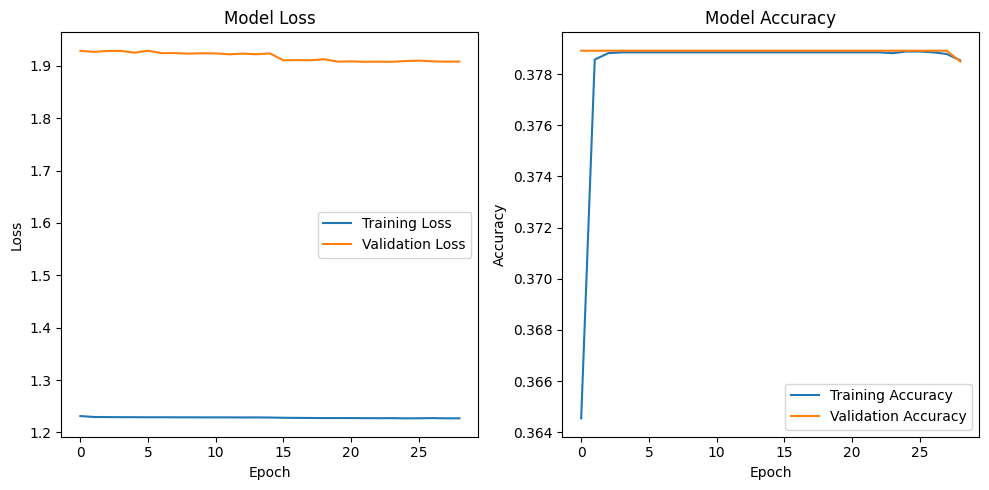

In [30]:
# ================================
# 13. MODEL EVALUATION
# ================================

print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_cls.history['loss'], label='Training Loss')
plt.plot(history_cls.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_cls.history['accuracy'], label='Training Accuracy')
plt.plot(history_cls.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(history.history['precision'], label='Training Precision')
# plt.plot(history.history['val_precision'], label='Validation Precision')
# plt.title('Model Precision')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.legend()

plt.tight_layout()
plt.show()

In [24]:
X_train.shape

(31669, 13)

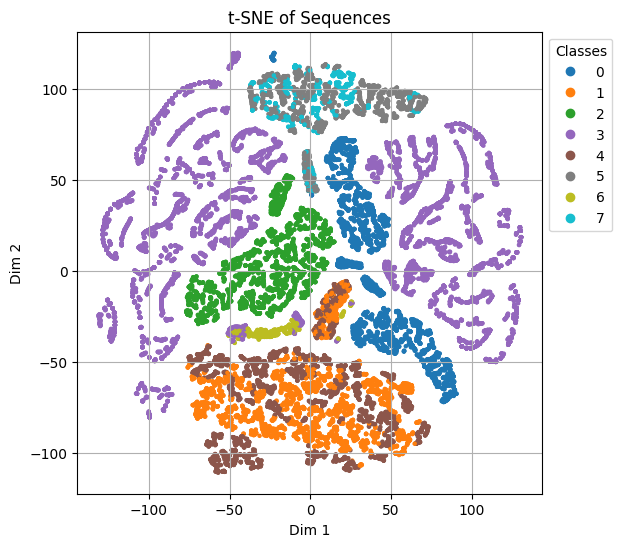

In [25]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(6,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1,1))
plt.title("t-SNE of Sequences")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()